# Sensor Data Fusion
Lecturer: Prof. Baum \
Tutor: Kolja Thormann \
Semester: Winter 21/22
## Homework 10

Consider the same motion model as in the last homework:

Assume a robot in 2D-space at position $\begin{bmatrix}x_1 & x_2\end{bmatrix}^T$ moving with velocity $v_1$ in $x_1$ direction and $v_2$ in $x_2$ direction. Its state is defined as $\textbf{x}=\begin{bmatrix}x_1 & x_2 & v_1 & v_2\end{bmatrix}^T$.


---
The following tasks will have missing sections marked that you should fill out. 

Missing code parts are marked by
```
# ... code code code
=== YOUR CODE HERE ===

=== END OF YOUR CODE ===
# ... code code code
```
If you are asked to implement a function, make sure to check what variable will be returned by the function and to fill it accordingly. Do not change code outside of the indicated sections.

Furthermore, some questions require theoretical answers instead of python code.

Such questions will have a field marked like this: 

=== YOUR ANSWER HERE === 

In [361]:
# import statements
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import math
from numpy.linalg import inv, norm

---
### a)
This time, instead of measuring the position directly, we measure the distance to a landmark $P_i$. Formulate the measurement equation and write a function implementing it.

For now, we will assume only a single landmark is used. In that case, the measurement noise will be a 1x1 matrix.

=== YOUR ANSWER HERE ===

In [362]:
def measurement_model_single(x, R, P):
    """
    Implements the measurement model for a single landmark.
    
    :param x: Robot location
    :param R: measurement Noise matrix. If only one landmark exists, will be of shape (1,1)
    :param P: landmark locations
    :return m: The measurement
    """
    
    assert R.shape == (1,1)
    
    # === YOUR CODE HERE ===
    x = np.array(x)
    P = np.array(P)

    m = np.linalg.norm(x[:2] - P) + np.random.normal(0, np.sqrt(R))
    
    # === END OF YOUR CODE ===
    
    return m

---
### b)
To use the measurement in the Kalman filter, we utilize the EKF formulas. Calculate the Jacobian of the measurement function from a) and implement the EKF measurement update.

Again, we assume that for now only one landmark exists, and $\textbf{R}$ will be a 1x1 matrix. 

=== YOUR ANSWER HERE ===

In [363]:
def update_single(x, x_cov, m, R, P):
    """
    Measurement update of the EKF for the case that there is one landmark.
    
    :param x: robot state
    :param x_cov: robot state covariance
    :param m: measurement
    :param R: measurement noise matrix
    :param P: landmark locations
    :return: (x_new, x_cov_new) the updated robot state and state covariance
    """
    # ensure everything is numpy
    x = np.array(x)
    x_cov = np.array(x_cov)
    m = np.array(m)
    R = np.array(R)
    P = np.array(P)
    
    assert R.shape == (1,1)
    # === YOUR CODE HERE ===
    
    print('x: ', x)
    print('P: ', P)

    curr_p = np.array(P[0])
    print('curr_p: ', curr_p)

    H = []
    H.append([(x[0] - curr_p[0]) / np.sqrt((x[0] - curr_p[0])**2 + (x[1] - curr_p[1])**2)])
    H.append([(x[1] - curr_p[1]) / np.sqrt((x[0] - curr_p[0])**2 + (x[1] - curr_p[1])**2)])
    H.append([0])
    H.append([0])
    H = np.array(H).T
    
    # print('H.shape: ', H.T)
    # print('x_cov.shape: ', x_cov.shape)
    print('x.shape: ', x.shape)
    print('P.shape: ', P.shape)

    K = x_cov @ H.T @ np.linalg.inv(H @ x_cov @ H.T + R)
    diff = np.sqrt((x[0] - curr_p[0])**2 + (x[1] - curr_p[1])**2)

    x_new = x + K @ (m - diff)
    x_cov_new = x_cov - K @ H @ x_cov

    # === END OF YOUR CODE ===
    
    return x_new, x_cov_new

The `predict` and `kalman_filter` functions are very similar to the ones from last exercise.

You do not need to implement these again.

In [364]:
def predict(x, x_cov, Q, F):
    """
    Function that implements the predict step of a Kalman Filter.
    
    :param x: Current state
    :param x_cov: Current state covariance matrix
    :param Q: transition noise matrix
    :param F: state transition matrix
    :return: (x_new, x_cov_new) The resulting state and covariance matrix after the predict step
    """
    
    x_new =  F @ x
    x_cov_new = F @ x_cov @ F.T + Q
    
    return x_new, x_cov_new

def kalman_filter(x_init, x_cov, ms, Q, R, F, P, update):
    """
    Function that runs the predict and update steps of a Kalman Filter.
    
    The update function is passed as a parameter to this function.
    
    :param x_init: Initial state
    :param x_cov: Initial state covariance matrix
    :param ms: Measurements 
    :param Q: transition noise matrix
    :param R: Measurement noise matrix
    :param F: state transition matrix
    :param P: landmark locations
    :param update: Update function for the Kalman Filter. Parameters: (x, x_cov, m, R, P)
    Will be either 'update_single' or, for the later part of the exercise, 'update_dual'
    :return: track, the resulting track after applying the kalman filter
    """
    # initial track
    track = np.zeros((ms.shape[0]+1,x_init.shape[0]))
    track[0, :] = x_init
    
    for i in range(1, ms.shape[0]+1):
        track[i, :], x_cov = predict(track[i-1, :].T, x_cov, Q, F)
        track[i, :], x_cov = update(track[i, :].T, x_cov, ms[i-1, :].T, R, P)
    
    return track

---
### c)
Your implementation will be used to track the robot, getting measurements from a single landmark $P_1=\begin{bmatrix}5 & 0\end{bmatrix}^T$. 


The measured distance is noise corrupted with Gaussian noise having zero mean and variance $0.1$. 

For the initial state and the process covariance, we will use


$$
\textbf{C}_{\text{init}}=\begin{bmatrix}0.1 & 0 & 0 & 0\\0 & 0.1 & 0 & 0\\0 & 0 & 0.1 & 0\\0 & 0 & 0 & 0.1\end{bmatrix}, \textbf{Q}=\begin{bmatrix}0.001 & 0 & 0 & 0\\0 & 0.001 & 0 & 0\\0 & 0 & 0.02 & 0\\0 & 0 & 0 & 0.02\end{bmatrix}
$$

For this, you will first need to implement the motion model of the robot:

In [365]:
# please implement the motion model of the robot:

def motion_model(x, Q, F):
    """
    Function that implements the motion model.
    :param x: current state
    :param Q: transition noise matrix
    :param F: state transition matrix
    :return: x_new, the new state
    """
    x = np.array(x)
    Q = np.array(Q)
    
    # === YOUR CODE HERE ===
    
    x_new = F @ x + np.random.multivariate_normal(np.zeros(F.shape[0]), Q)
    
    # === END OF YOUR CODE ===
    
    return x_new

In [366]:
# def. of the function used to simulate all time steps to generate the ground truth and measurements
def simulation(x_init, x_init_cov, Q, R, F, P, steps, measurement):
    """
    :param x_init: Initial state
    :param x_init_cov: Initial state covariance matrix
    :param Q: transition noise matrix
    :param R: measurement noise matrix
    :param F: state transition matrix
    :param steps: Number of steps to run the simulation for
    :param measurement: Function that takes (x,R,P) and returns a measurement for it
    :return: (track, ms) with track being the ground truth track, and ms the measurements produced in the simulation.
    """
    x_dim = len(x_init)
    
    track = np.zeros((steps, x_dim))
    ms = np.zeros((steps-1, R.shape[0]))
    
    track[0, :] = np.random.multivariate_normal(x_init, x_init_cov)
    
    for i in range(1, steps):
        track[i, :] = motion_model(track[i-1, :].T, Q, F)
        ms[i-1, :] = measurement(track[i, :].T, R, P)
    
    # track should have "steps" many entries of states of correct dimension
    assert track.shape == (steps, x_dim)  
    
    # one less measurement (no measurement for the initial state) and measurements are of dim len(R)
    assert ms.shape == (steps-1, R.shape[0])  
    
    return track, ms

---
Using these functions, the simulation will now be run and the results will be visualized.

x:  [0.5 0.5 0.5 0.5]
P:  [[5 0]]
curr_p:  [5 0]
x.shape:  (4,)
P.shape:  (1, 2)
x:  [1.1715649  0.98093723 0.5569983  0.49366686]
P:  [[5 0]]
curr_p:  [5 0]
x.shape:  (4,)
P.shape:  (1, 2)
x:  [1.78061789 1.45206977 0.57541854 0.48665372]
P:  [[5 0]]
curr_p:  [5 0]
x.shape:  (4,)
P.shape:  (1, 2)
x:  [2.29773665 2.02363751 0.55543779 0.50882288]
P:  [[5 0]]
curr_p:  [5 0]
x.shape:  (4,)
P.shape:  (1, 2)
x:  [2.89007847 1.35496993 0.60021033 0.24628872]
P:  [[5 0]]
curr_p:  [5 0]
x.shape:  (4,)
P.shape:  (1, 2)
x:  [3.55245261 1.58105967 0.6182792  0.23821444]
P:  [[5 0]]
curr_p:  [5 0]
x.shape:  (4,)
P.shape:  (1, 2)
x:  [4.40937934 2.45523872 0.6440312  0.35485203]
P:  [[5 0]]
curr_p:  [5 0]
x.shape:  (4,)
P.shape:  (1, 2)
x:  [4.9281297  2.66240933 0.62358941 0.33256479]
P:  [[5 0]]
curr_p:  [5 0]
x.shape:  (4,)
P.shape:  (1, 2)
x:  [6.13311728 3.60069919 0.72513337 0.4639561 ]
P:  [[5 0]]
curr_p:  [5 0]
x.shape:  (4,)
P.shape:  (1, 2)


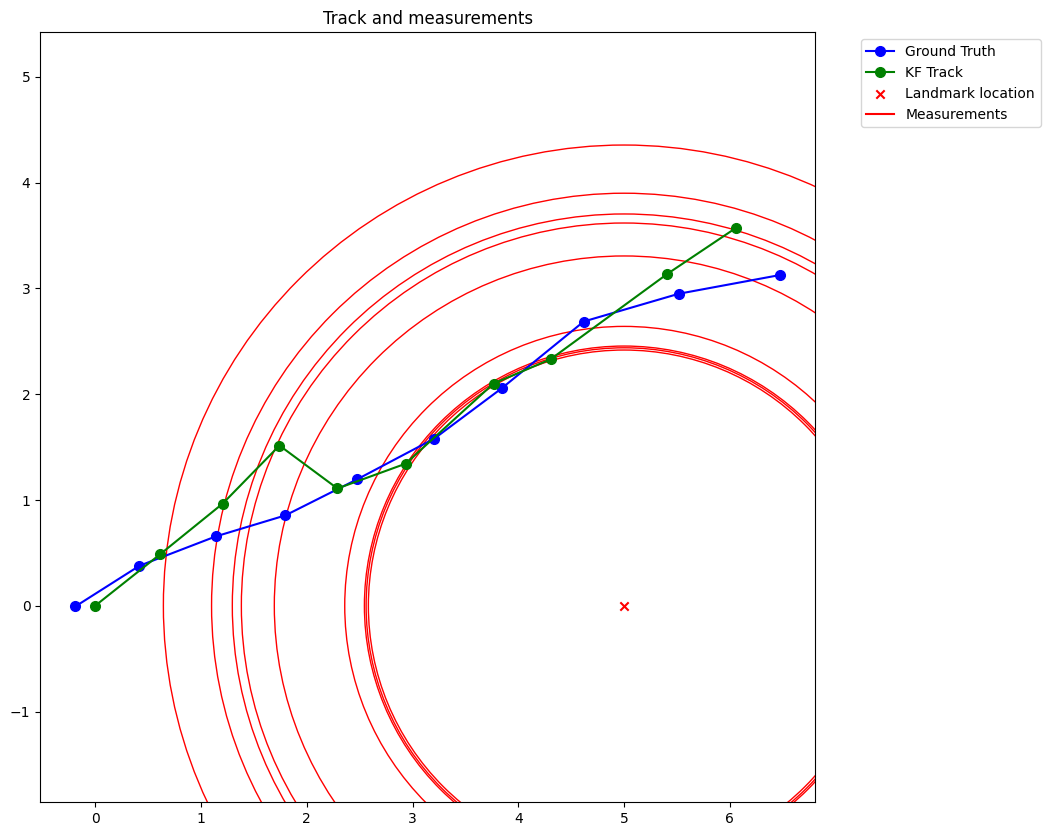

In [367]:
# init variables and run simulation:

t = 1
steps = 10
n = 100

x_init = np.array([0, 0, 0.5, 0.5])
x_cov = np.array([
    [0.1, 0, 0, 0],
    [0, 0.1, 0, 0],
    [0, 0, 0.1, 0],
    [0, 0, 0, 0.1]
])

Q = np.array([
    [0.001, 0, 0, 0],
    [0, 0.001, 0, 0],
    [0, 0, 0.02, 0],
    [0, 0, 0, 0.02]
])

R = np.array([[0.1]])

F = np.array([
    [1, 0, t, 0],
    [0, 1, 0, t],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

P = np.array([[5, 0]])

# run simulation
gt, ms = simulation(x_init, x_cov, Q, R, F, P, steps, measurement=measurement_model_single)
track = kalman_filter(x_init, x_cov, ms, Q, R, F, P, update=update_single)

# Visualize the results of the simulation:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(gt[:, 0], gt[:, 1], c="b", label="Ground Truth", markersize=7, marker="o")
ax.plot(track[:, 0], track[:, 1], c="g", label="KF Track", markersize=7, marker="o")
ax.scatter(P[:, 0], P[:, 1], c="r", label="Landmark location", marker="x")

for i, lm in enumerate(ms.T):
    # get the measurement for the first landmark
    for y in lm:
        c = plt.Circle((P[i, 0], P[i, 1]), y, color='r', fill=False)
        ax.add_artist(c)

ax.axis("equal")
plt.title("Track and measurements")
handles, labels = ax.get_legend_handles_labels()
handles.append(mlines.Line2D([], [], color='red'))
labels.append("Measurements")
plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

---
### d)
To improve your estimate, use a second landmark $P_2=\begin{bmatrix}0 & 5\end{bmatrix}^T$. Formulate a stacked measurement equation and calculate the corresponding Jacobian.

You will need to implement new versions of your `measurement_model` and your `update` functions. 

Hints:
- since we are now dealing with a multi-dimensional scenario, you should consider using `np.random.multivariate_normal` instead of `np.random.normal`.
- make sure you calculate the distances between x and P across the correct axis, since P is now multi-dimensional too.

In [368]:
def measurement_model_dual(x, R, P):
    """
    Implements the measurement model for the two landmark case.
    
    :param x: Robot location
    :param R: measurement Noise matrix. If two landmarks exists, will be of shape (2,2)
    :param P: landmark locations
    :return m: The measurement
    """
    assert R.shape == (2,2)
    
    # === YOUR CODE HERE ===
    
    m = np.array([
        np.linalg.norm(x[:2] - P[0]) + np.random.normal(0, np.sqrt(R[0, 0])),
        np.linalg.norm(x[:2] - P[1]) + np.random.normal(0, np.sqrt(R[1, 1])),
    ])

    # === END OF YOUR CODE ===
    
    return m

In [369]:
def update_dual(x, x_cov, m, R, P):
    """
    Measurement update of the EKF for the case that there are two landmarks.
    
    :param x: robot state
    :param x_cov: robot state covariance
    :param m: measurement
    :param R: measurement noise matrix
    :param P: landmark locations
    :return: (x_new, x_cov_new) the updated robot state and state covariance
    """
    # ensure everything is numpy
    x = np.array(x)
    x_cov = np.array(x_cov)
    m = np.array(m)
    R = np.array(R)
    P = np.array(P)
    
    assert R.shape == (2,2)
    
    # === YOUR CODE HERE ===
    
    H = []
    for curr_p in P:
        partial_derivative = []
        partial_derivative.append((curr_p[0] + x[0]) / np.sqrt((curr_p[0] + x[0])**2 + (curr_p[1] + x[1])**2))
        partial_derivative.append((curr_p[1] + x[1]) / np.sqrt((curr_p[0] + x[0])**2 + (curr_p[1] + x[1])**2))
        partial_derivative.append(0)
        partial_derivative.append(0)
        H.append(partial_derivative)
    H = np.array(H)

    print('H: ', H)

    K = x_cov @ H.T @ np.linalg.inv(H @ x_cov @ H.T + R)
    h = np.linalg.norm(m - x[:2])
    x_new = x + K @ (m - h)
    x_cov_new = x_cov - K @ H @ x_cov

    # === END OF YOUR CODE ===
    
    return x_new, x_cov_new

---
Now, with the new measurement model and update functions, we run the simulation again, but this time using two landmarks.

H:  [[0.99589321 0.09053575 0.         0.        ]
 [0.09053575 0.99589321 0.         0.        ]]
H:  [[ 0.99914539 -0.04133379  0.          0.        ]
 [ 0.03355672  0.99943681  0.          0.        ]]
H:  [[ 0.82136231 -0.57040683  0.          0.        ]
 [-0.4480553   0.89400585  0.          0.        ]]
H:  [[-0.073152   -0.9973208   0.          0.        ]
 [-0.92847963 -0.37138333  0.          0.        ]]
H:  [[0.9889026  0.14856531 0.         0.        ]
 [0.49588043 0.86839081 0.         0.        ]]
H:  [[0.99023649 0.13939758 0.         0.        ]
 [0.74638901 0.66550991 0.         0.        ]]
H:  [[0.99743505 0.07157734 0.         0.        ]
 [0.89385156 0.44836301 0.         0.        ]]
H:  [[ 0.99935686 -0.03585911  0.          0.        ]
 [ 0.95855629  0.2849032   0.          0.        ]]
H:  [[ 0.98429073 -0.17655526  0.          0.        ]
 [ 0.99464779  0.10332366  0.          0.        ]]


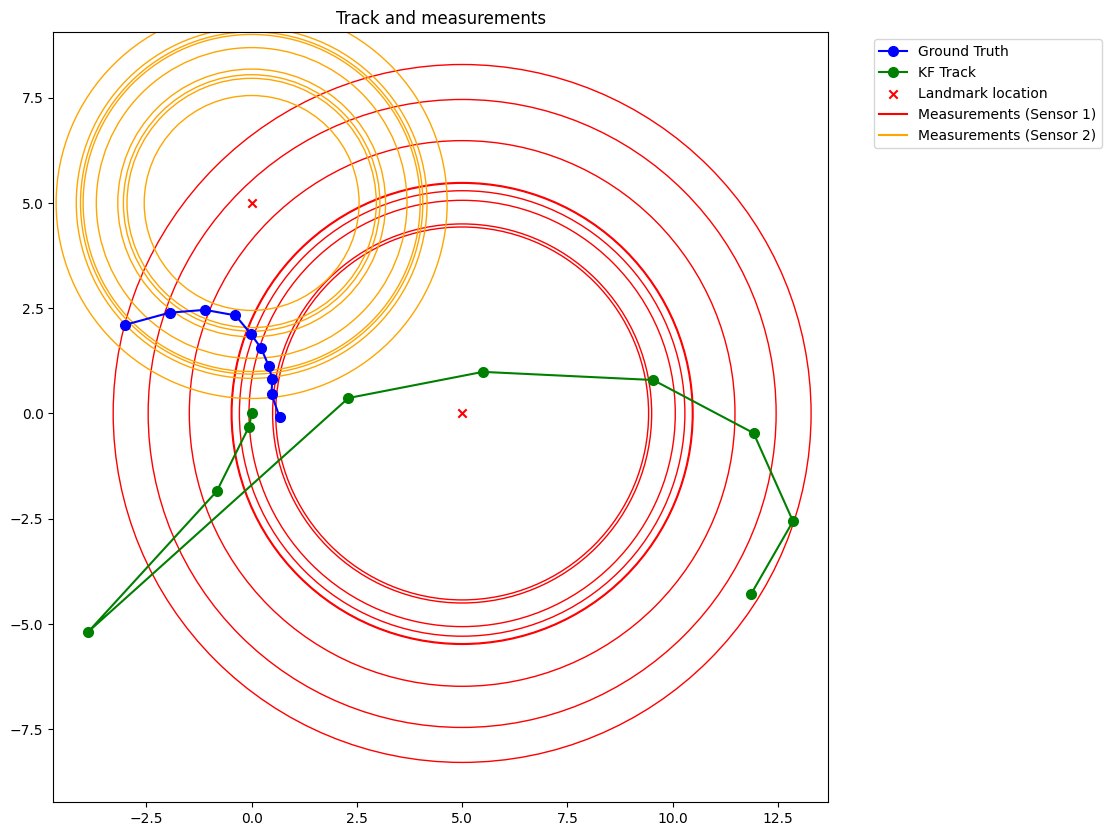

In [370]:
# init variables and run simulation:

t = 1
steps = 10
n = 100

x_init = np.array([0, 0, 0.5, 0.5])
x_cov = np.array([
    [0.1, 0, 0, 0],
    [0, 0.1, 0, 0],
    [0, 0, 0.1, 0],
    [0, 0, 0, 0.1]
])

Q = np.array([
    [0.001, 0, 0, 0],
    [0, 0.001, 0, 0],
    [0, 0, 0.02, 0],
    [0, 0, 0, 0.02]
])

R = np.array([
    [0.1, 0],
    [0, 0.1]
])

F = np.array([
    [1, 0, t, 0],
    [0, 1, 0, t],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
])

P = np.array([
    [5, 0],
    [0, 5]
])

# run simulation
gt, ms = simulation(x_init, x_cov, Q, R, F, P, steps, measurement=measurement_model_dual)
track = kalman_filter(x_init, x_cov, ms, Q, R, F, P, update=update_dual)

# Visualize the results of the simulation:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(gt[:, 0], gt[:, 1], c="b", label="Ground Truth", markersize=7, marker="o")
ax.plot(track[:, 0], track[:, 1], c="g", label="KF Track", markersize=7, marker="o")
ax.scatter(P[:, 0], P[:, 1], c="r", label="Landmark location", marker="x")

lm_c = ["red", "orange"]
for i, lm in enumerate(ms.T):
    # get the measurement for the first landmark
    for y in lm:
        c = plt.Circle((P[i, 0], P[i, 1]), y, color=lm_c[i], fill=False)
        ax.add_artist(c)

ax.axis("equal")
plt.title("Track and measurements")
handles, labels = ax.get_legend_handles_labels()
handles.append(mlines.Line2D([], [], color='red'))
labels.append("Measurements (Sensor 1)")
handles.append(mlines.Line2D([], [], color='orange'))
labels.append("Measurements (Sensor 2)")
plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()